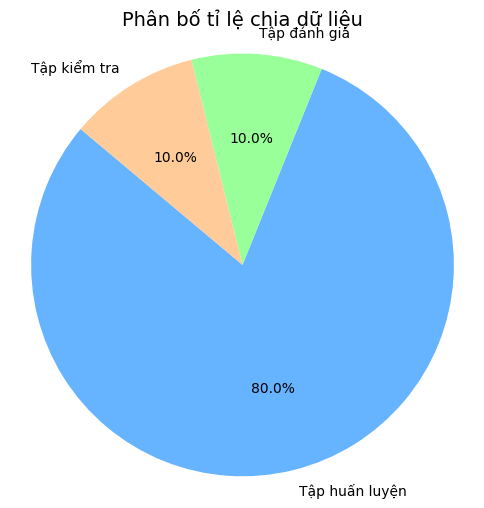

In [17]:
import matplotlib.pyplot as plt

# Tỉ lệ chia dữ liệu (ví dụ)
sizes = [80, 10, 10]
labels = ['Tập huấn luyện', 'Tập đánh giá', 'Tập kiểm tra']
colors = ['#66b3ff', '#99ff99', '#ffcc99']

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, textprops={'fontsize':10})
plt.title('Phân bố tỉ lệ chia dữ liệu', fontsize=14)
plt.axis('equal')  # Đảm bảo biểu đồ hình tròn
plt.show()


In [1]:
import os
import pytorch_lightning as pl
# your favorite machine learning tracking tool
from pytorch_lightning.loggers import WandbLogger

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import random_split, DataLoader
from torchvision.models import mobilenet_v2


from torchmetrics import Accuracy

from torchvision import transforms
from torchvision.datasets import ImageFolder

import wandb


/home/linh/miniconda3/envs/torch2tf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CustomImageFolderDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, data_dir: str = 'paddy-disease-classification/train_images'):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

        # Augmentation for training
        self.train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

        # Basic transform for val/test
        self.test_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def setup(self, stage=None):
        # Load full dataset with no transform first
        full_dataset = ImageFolder(root=self.data_dir)

        # Split indices
        total_size = len(full_dataset)
        train_size = int(0.8 * total_size)
        val_size = int(0.1 * total_size)
        test_size = total_size - train_size - val_size

        # Random split with fixed seed
        train_data, val_data, test_data = random_split(
            full_dataset, [train_size, val_size, test_size],
            generator=torch.Generator().manual_seed(42)
        )

        # Apply transform manually per split
        train_data.dataset.transform = self.train_transform
        val_data.dataset.transform = self.test_transform
        test_data.dataset.transform = self.test_transform

        self.train_dataset = train_data
        self.val_dataset = val_data
        self.test_dataset = test_data

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

In [3]:
class LitModel(pl.LightningModule):
    def __init__(self, input_shape, num_classes, learning_rate=2e-4):
        super().__init__()
        
        # log hyperparameters
        self.save_hyperparameters()
        self.learning_rate = learning_rate

        # Load pretrained MobileNetV2
        self.model = mobilenet_v2(pretrained=True)

        # Thay thế classifier cuối cùng: MobileNetV2 có classifier là nn.Sequential với 2 layer
        # Layer cuối cùng là nn.Linear với in_features = 1280 (đã cố định trong mobilenet_v2)
        in_features = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Linear(in_features, num_classes)

        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes)

    # returns the size of the output tensor going into Linear layer from the conv block.

    # returns the feature tensor from the conv block

    # will be used during inference
    def forward(self, x):
        return self.model(x)

    
  
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)  # ✅ dùng cross_entropy

        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, logger=True)

        return loss
        

    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        # validation metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        
        # validation metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

dm = CustomImageFolderDataModule(batch_size=32)
# To access the x_dataloader we need to call prepare_data and setup.
dm.prepare_data()
dm.setup()

# Samples required by the custom ImagePredictionLogger callback to log image predictions.
val_samples = next(iter(dm.val_dataloader()))
val_imgs, val_labels = val_samples[0], val_samples[1]
val_imgs.shape, val_labels.shape

model = LitModel.load_from_checkpoint("mobilenet-best.ckpt")

/home/linh/miniconda3/envs/torch2tf/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/linh/miniconda3/envs/torch2tf/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
trainer = pl.Trainer(max_epochs=200,
                     devices=[0], 
                     
                                # accelerator="auto"
                                )

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [18]:
from torchvision.datasets import ImageFolder

# Đường dẫn thư mục train_images
data_dir = 'paddy-disease-classification/train_images'

# Load dataset chỉ để lấy class names
dataset = ImageFolder(root=data_dir)
class_names = dataset.classes  # Đây là danh sách tên class tự động lấy từ folder

print("Tên các class:", class_names)


Tên các class: ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']


/home/linh/miniconda3/envs/torch2tf/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/linh/miniconda3/envs/torch2tf/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Classification Report:
                          precision    recall  f1-score   support

   bacterial_leaf_blight     0.9194    0.9194    0.9194        62
   bacterial_leaf_streak     1.0000    0.9722    0.9859        36
bacterial_panicle_blight     0.9286    0.9512    0.9398        41
                   blast     0.9651    0.9379    0.9513       177
              brown_spot     0.9560    0.9158    0.9355        95
              dead_heart     0.9933    0.9867    0.9900       150
            downy_mildew     0.8621    0.9091    0.8850        55
                   hispa     0.9070    0.9750    0.9398       160
                  normal     0.9521    0.9578    0.9550       166
                  tungro     0.9681    0.9100    0.9381       100

                accuracy                         0.9482      1042
               macro avg     0.9452    0.9435    0.9440      1042
            weighted avg     0.9492    0.9482    0.9483      1042



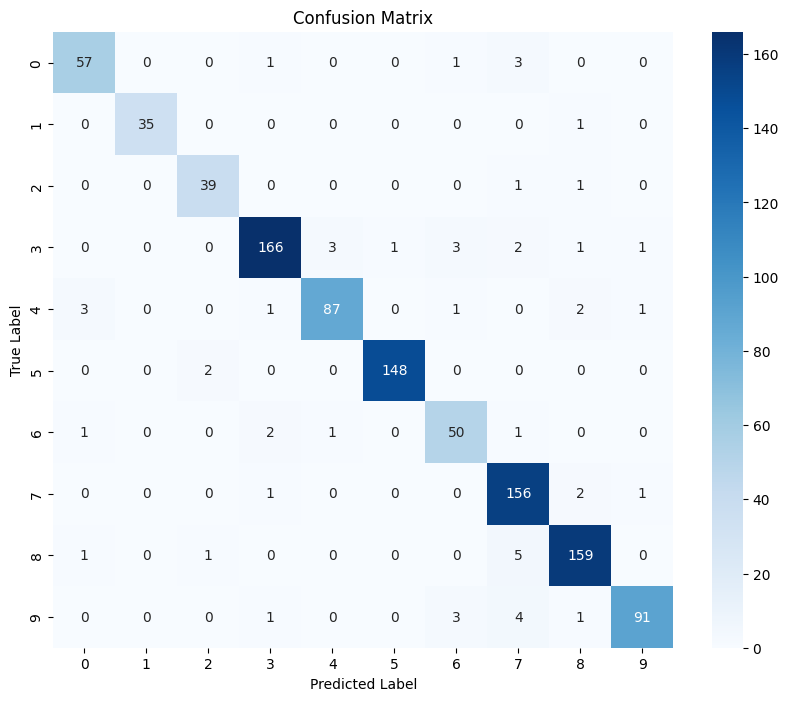

In [ ]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torchvision.datasets import ImageFolder

# 0. Get class names from the dataset folder
data_dir = 'paddy-disease-classification/train_images'
dataset = ImageFolder(root=data_dir)
class_names = dataset.classes  # Automatically extracted class names

# 1. Load the model
model = LitModel.load_from_checkpoint("mobilenet-best.ckpt", num_classes=len(class_names))
model.eval().cuda()

# 2. Get the test dataloader
dm = CustomImageFolderDataModule(batch_size=32)
dm.prepare_data()
dm.setup()
test_loader = dm.test_dataloader()

# 3. Collect predictions and ground truth
all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.cuda(), y.cuda()
        logits = model(x)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# 4. Compute confusion matrix and classification report
conf_matrix = confusion_matrix(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)

# 5. Print classification report
print("Classification Report:")
print(class_report)

# 6. Plot confusion matrix with class names
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
